<a href="https://colab.research.google.com/github/AtomZa/LowNColab/blob/main/EvoTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/ElArkk/jax-unirep.git --upgrade
!pip install biopython
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ElArkk/jax-unirep.git to /tmp/pip-req-build-uqciwf1v
  Running command git clone --filter=blob:none --quiet https://github.com/ElArkk/jax-unirep.git /tmp/pip-req-build-uqciwf1v
  Resolved https://github.com/ElArkk/jax-unirep.git to commit 7763bf69cc7864f8cf466151e452c52f3adc6476
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 27.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 36.1 MB/s eta 0:00:00


# Pre-Evotuning

In [ ]:
from Bio import SeqIO
import pandas as pd
import re
from Levenshtein import distance
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Functions:

# read FASTA file:
# input: file name
# output: names and sequences in the file as an array of dim-2 arrays [name, sequence].
def read_fasta(name):
    fasta_seqs = SeqIO.parse(open('/content/' + name + '.fasta'),'fasta')
    data = []
    for fasta in fasta_seqs:
        data.append([fasta.id, str(fasta.seq).strip()])
    
    return data


# write FASTA file:
# input: file name; df to write
def write_fasta(name, seqs_df):
    out_file = open('/content/' + name + '.fasta.txt', "w")
    for i in range(len(seqs_df)):
        out_file.write('>' + seqs_df.name[i] + '\n')
        out_file.write(seqs_df.sequence[i] + '\n')
    out_file.close()


# input: takes in a sequence
# output: True if a sequence contains only standard amino acids, returns False if contains non-standard ones.
def validate(seq, pattern=re.compile(r'^[FIWLVMYCATHGSQRKNEPD]+$')):
    if (pattern.match(seq)):
        return True
    return False

    
# Remove sequences longer than k residues and with non-standard residues
# inputs: seqs_df = dataframe of name, sequence; k = max lenght of residues to keep
# output: cleaned dataframe
def clean(seqs_df, k):
    # remove sequences with length > 1000 AA's
    rows2drop = []
    for i in range(len(seqs_df)):
        if (len(seqs_df.sequence[i]) > k):
            rows2drop.append(i)

    print('Total number of sequences dropped due to length >', k, ':', len(rows2drop))

    seqs_df = seqs_df.drop(rows2drop).reset_index().drop('index', axis=1)

    print('Total number of sequences remaining:', len(seqs_df))
    
    # remove sequences with invalid AA residues
    # valid_alphabet = ['F','I','W','L','V','M','Y','C','A','T','H','G','S','Q','R','K','N','E','P','D']
    invalid_seqs = []

    for i in range(len(seqs_df)):
        if (not validate(seqs_df.sequence[i])):
            invalid_seqs.append(i)

    print('Total number of invalid sequences dropped:', len(invalid_seqs))

    seqs_df = seqs_df.drop(invalid_seqs).reset_index().drop('index', axis=1)

    print('Total number of valid sequences remaining:', len(seqs_df))
    
    
    seqs_df = seqs_df.drop_duplicates(subset='sequence').reset_index().drop('index', axis=1)

    print('Total sequences remaining after duplicate removal', len(seqs_df))

    
    return seqs_df


# calculate the Levenstein distance of mulitple sequences to a target sequence
# also plots a histogram of distances
# inputs: t_seq = target sequence; seqs_df = dataframe of sequences;
# num_bins = bins for histogram; hist_range = range for histogram
# outputs: numpy array of distances
def lev_dist(t_seq, seqs_df, num_bins=20, hist_range=(0,350)):
    distances = []
    for i in range(len(seqs_df)):
        distances.append(distance(t_seq, seqs_df.sequence[i]))
    distances = np.array(distances)

    mean_dist = np.mean(distances)
    median_dist = np.median(distances)
    min_dist = np.min(distances)
    max_dist = np.max(distances)
    
    print("Mean Levenstein distance:", mean_dist)
    print("Median Levenstein distance:", mean_dist)
    print("Min Levenstein distance:", min_dist)
    print("Max Levenstein distance:", max_dist)

    
    # histogram of Levenstein distances from target sequence
    plt.clf()
    plt.hist(distances, bins=num_bins, range=hist_range)
    plt.show()
    
    return distances



"""
File formatting note.
Data should be preprocessed as a sequence of comma-seperated ints with
sequences  /n seperated
"""

# Lookup tables
aa_to_int = {
    'M':1,
    'R':2,
    'H':3,
    'K':4,
    'D':5,
    'E':6,
    'S':7,
    'T':8,
    'N':9,
    'Q':10,
    'C':11,
    'U':12,
    'G':13,
    'P':14,
    'A':15,
    'V':16,
    'I':17,
    'F':18,
    'Y':19,
    'W':20,
    'L':21,
    'O':22, #Pyrrolysine
    'X':23, # Unknown
    'Z':23, # Glutamic acid or GLutamine
    'B':23, # Asparagine or aspartic acid
    'J':23, # Leucine or isoleucine
    'start':24,
    'stop':25,
}

int_to_aa = {value:key for key, value in aa_to_int.items()}

def get_aa_to_int():
    """
    Get the lookup table (for easy import)
    """
    return aa_to_int

def get_int_to_aa():
    """
    Get the lookup table (for easy import)
    """
    return int_to_aa
    
def aa_seq_to_int(s):
    """
    Return the int sequence as a list for a given string of amino acids
    """
    return [24] + [aa_to_int[a] for a in s] + [25]

def int_seq_to_aa(s):
    """
    Return the int sequence as a list for a given string of amino acids
    """
    return "".join([int_to_aa[i] for i in s])

    
def format_seq(seq,stop=False):
    """
    Takes an amino acid sequence, returns a list of integers in the codex of the babbler.
    Here, the default is to strip the stop symbol (stop=False) which would have 
    otherwise been added to the end of the sequence. If you are trying to generate
    a rep, do not include the stop. It is probably best to ignore the stop if you are
    co-tuning the babbler and a top model as well.
    """
    if stop:
        int_seq = aa_seq_to_int(seq.strip())
    else:
        int_seq = aa_seq_to_int(seq.strip())[:-1]
    return int_seq

def is_valid_seq(seq, max_len=2000):
    """
    True if seq is valid for the babbler, False otherwise.
    """
    l = len(seq)
    valid_aas = "MRHKDESTNQCUGPAVIFYWLO"
    if (l < max_len) and set(seq) <= set(valid_aas):
        return True
    else:
        return False

def fasta_to_input(in_path):
    source = SeqIO.parse(in_path + '.fasta.txt','fasta')
    with open(in_path + "_formatted.fasta.txt", "w") as destination:
        for seq in fasta_seqs:
            seq = seq.strip()
            if is_valid_seq(seq) and len(seq) < 275: 
                formatted = ",".join(map(str,format_seq(seq)))
                destination.write(formatted)
                destination.write('\n')

def seqs_to_input(name, in_seqs, stop=False):
    with open('outputs/' + name + "_formatted.fasta.txt", "w") as destination:
        for seq in in_seqs:
            seq = seq.strip()
            if is_valid_seq(seq): 
                formatted = ",".join(map(str,format_seq(seq, stop=stop)))
                destination.write(formatted)
                destination.write('\n')


In [ ]:
# input FASTA files:
in_fastas = ['protein-matching-IPR001466'
            ]

# put sequences into a pandas dataframes
sequences_df = pd.concat([pd.DataFrame(read_fasta(in_fastas[i]), columns = ['name', 'sequence']) for i in range(len(in_fastas))], axis=0).reset_index().drop('index', axis=1)

print('Total number of input sequences:', len(sequences_df))

# clean the sequences:
# the number here is the AA length we want - set to 350
clean_seqs_df = clean(sequences_df, 600)

# save clean sequences as a .fasta.txt file
write_fasta('2MS2_all_sequences_clean', clean_seqs_df)

Total number of input sequences: 97
Total number of sequences dropped due to length > 600 : 2
Total number of sequences remaining: 95
Total number of invalid sequences dropped: 0
Total number of valid sequences remaining: 95
Total sequences remaining after duplicate removal 76


In [ ]:
# load target sequence
target_fasta = 'rcsb_pdb_1ZG4'
targets = read_fasta(target_fasta)
print(targets[0][0])
print(targets[0][1])


1ZG4_1|Chain
MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRIDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPVAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW


Mean Levenstein distance: 341.7105263157895
Median Levenstein distance: 341.7105263157895
Min Levenstein distance: 208
Max Levenstein distance: 461


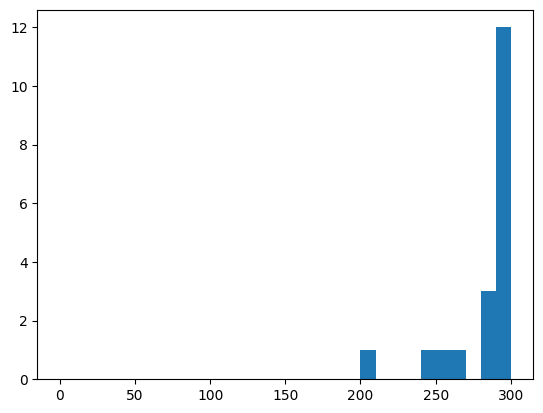

In [ ]:
# calculate levenstein distance from chosen target sequence
distances = lev_dist(targets[0][1], clean_seqs_df, 30, (0,300))

In [ ]:
# filter by lev distance
clean_seqs_df['dist'] = distances
close_seqs_df = clean_seqs_df[clean_seqs_df['dist'] <= 300]
print(len(close_seqs_df))

19


In [ ]:
# partition into the training and 2 validation sets:

close_seqs_df_copy = close_seqs_df.copy()
out_domain_val_set = close_seqs_df_copy.sample(frac=0.1, weights=close_seqs_df['dist']**4, random_state=17)
remainder_df = close_seqs_df_copy.drop(out_domain_val_set.index)
#train_set = remainder_df.sample(frac=0.889, random_state=17)
#in_domain_val_set = remainder_df.drop(train_set.index)

Out of domain validation set size: 2
Mean Levenstein distance: 295.5
Median Levenstein distance: 295.5
Min Levenstein distance: 291
Max Levenstein distance: 300


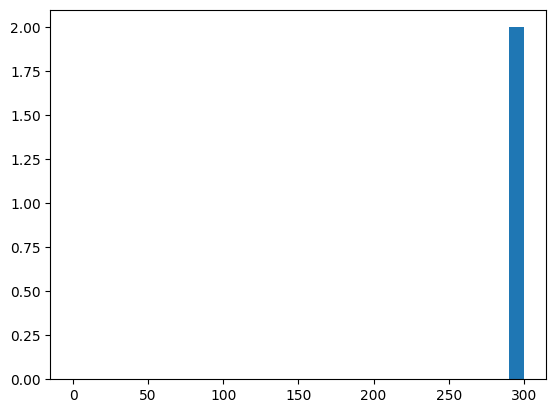

Training set size: 17
Mean Levenstein distance: 280.88235294117646
Median Levenstein distance: 280.88235294117646
Min Levenstein distance: 208
Max Levenstein distance: 298


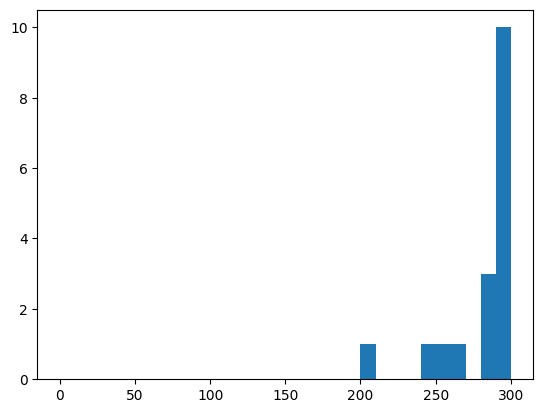

In [ ]:

# set check sizes and levenstein distances
print('Out of domain validation set size:', len(out_domain_val_set))
out_dom_distances = lev_dist(targets[0][1], out_domain_val_set.reset_index().drop('index', axis=1), 30, (0,300))

#print('In domain validation set size:', len(in_domain_val_set))

print('Training set size:', len(remainder_df))
training_distances = lev_dist(targets[0][1], remainder_df.reset_index().drop('index', axis=1), 30, (0,300))

In [ ]:
# save to fasta file formats:

write_fasta('TEM1_train_set', remainder_df.reset_index().drop('index', axis=1))
write_fasta('TEM1_out_domain_val_set', out_domain_val_set.reset_index().drop('index', axis=1))
#write_fasta('in_domain_val_set', in_domain_val_set.reset_index().drop('index', axis=1))

In [ ]:
# read_fasta("TEM1_train_set")
!wc "/content/TEM1_train_set.fasta"

  34   34 6913 /content/TEM1_train_set.fasta


# Evotuning

In [ ]:
"""Evotuning two ways!"""

from pathlib import Path

from jax.random import PRNGKey

from jax_unirep import evotune
from jax_unirep.evotuning_models import mlstm64
from jax_unirep.utils import dump_params

# Test sequences:
sequences = ["HASTA", "VISTA", "ALAVA", "LIMED", "HAST", "HAS", "HASVASTA"] * 5
holdout_sequences = [
    "HASTA",
    "VISTA",
    "ALAVA",
    "LIMED",
    "HAST",
    "HASVALTA",
] * 5
PROJECT_NAME = "evotuning_temp"

init_fun, apply_fun = mlstm64()

# The input_shape is always going to be (-1, 26),
# because that is the number of unique AA, one-hot encoded.
_, inital_params = init_fun(PRNGKey(42), input_shape=(-1, 26))

# 1. Evotuning with Optuna
n_epochs_config = {"low": 1, "high": 1}
lr_config = {"low": 1e-5, "high": 1e-3}
study, evotuned_params = evotune(
    sequences=sequences,
    model_func=apply_fun,
    params=inital_params,
    out_dom_seqs=holdout_sequences,
    n_trials=2,
    n_splits=2,
    n_epochs_config=n_epochs_config,
    learning_rate_config=lr_config,
)

dump_params(evotuned_params, Path(PROJECT_NAME))
print("Evotuning done! Find output weights in", PROJECT_NAME)
print(study.trials_dataframe())

[I 2023-04-10 23:58:06,194] A new study created in memory with name: no-name-89ac4dd0-805a-454f-a3ff-4afd44923c5c
/usr/local/lib/python3.9/dist-packages/jax_unirep/evotuning.py:464: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  n_epochs = trial.suggest_discrete_uniform(**n_epochs_kwargs)
/usr/local/lib/python3.9/dist-packages/jax_unirep/evotuning.py:465: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform(**learning_rate_kwargs)


right-padding sequences:   0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:evotuning:Random batching done: All sequences padded to max sequence length of 8


Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:evotuning:Calculations for training set:
INFO:evotuning:Epoch 0: Estimated average loss: 0.153677836060524. 


created directory at temp


  0%|          | 0/4 [00:00<?, ?it/s]

INFO:evotuning:Split #1


right-padding sequences:   0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:evotuning:Random batching done: All sequences padded to max sequence length of 8


Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:evotuning:Calculations for training set:
INFO:evotuning:Epoch 0: Estimated average loss: 0.1536562144756317. 


  0%|          | 0/4 [00:00<?, ?it/s]

[I 2023-04-10 23:58:49,673] Trial 0 finished with value: 0.14550049602985382 and parameters: {'n_epochs': 1.0, 'learning_rate': 1.899411177990893e-05}. Best is trial 0 with value: 0.14550049602985382.
INFO:evotuning:Trying out 1.0 epochs with learning rate 0.0002546360805299253.
INFO:evotuning:Split #0


right-padding sequences:   0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:evotuning:Random batching done: All sequences padded to max sequence length of 8


Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:evotuning:Calculations for training set:
INFO:evotuning:Epoch 0: Estimated average loss: 0.15366674959659576. 


  0%|          | 0/4 [00:00<?, ?it/s]

INFO:evotuning:Split #1


right-padding sequences:   0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:evotuning:Random batching done: All sequences padded to max sequence length of 8


Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:evotuning:Calculations for training set:
INFO:evotuning:Epoch 0: Estimated average loss: 0.15366671979427338. 


  0%|          | 0/4 [00:00<?, ?it/s]

[I 2023-04-10 23:59:23,256] Trial 1 finished with value: 0.1455235779285431 and parameters: {'n_epochs': 1.0, 'learning_rate': 0.0002546360805299253}. Best is trial 0 with value: 0.14550049602985382.
INFO:evotuning:Optuna done, starting tuning with learning rate=1.899411177990893e-05, 


right-padding sequences:   0%|          | 0/35 [00:00<?, ?it/s]

right-padding sequences:   0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:evotuning:Random batching done: All sequences padded to max sequence length of 8


Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:evotuning:Calculations for training set:
INFO:evotuning:Epoch 0: Estimated average loss: 0.15366563200950623. 
INFO:evotuning:Calculations for holdout set:
INFO:evotuning:Epoch 0: Estimated average loss: 0.15367169678211212. 


created directory at evotuning_temp
Evotuning done! Find output weights in evotuning_temp
   number     value             datetime_start          datetime_complete  \
0       0  0.145500 2023-04-10 23:58:06.196817 2023-04-10 23:58:49.672801   
1       1  0.145524 2023-04-10 23:58:49.675309 2023-04-10 23:59:23.255741   

                duration  params_learning_rate  params_n_epochs     state  
0 0 days 00:00:43.475984              0.000019              1.0  COMPLETE  
1 0 days 00:00:33.580432              0.000255              1.0  COMPLETE  


# Problem: 
1. fitness?
2. eUnirep -> get_reps Error